In [1]:
%load_ext autoreload
%autoreload 2

import os, subprocess, urllib, tempfile, importlib

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import cortex as cx

from nilearn.surface import load_surf_data
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter, zoom

import popylar

/Users/knapen/software/miniconda3/envs/popylar/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


### Download data for demonstration

In [2]:
#
# download a pycortex subject (flatmap, etc) 
# of the 1.6 mm HCP standard surfaces from figshare
#

if not os.path.exists(os.path.join(cx.database.default_filestore, 'hcp_999999')):
    pycortex_sj_URL = "https://ndownloader.figshare.com/files/25768841"

    tempfolder = tempfile.gettempdir()
    urllib.request.urlretrieve(pycortex_sj_URL, os.path.join(tempfolder, 'hcp_999999.zip'))
    subprocess.run(['unzip', '-q', '-n', 
                    os.path.join(tempfolder, "hcp_999999.zip"), 
                    '-d', cx.database.default_filestore])

#
# and then download several projects' data from figshare
# and extract the prf experiment data
#
with importlib.resources.files(popylar) as package:
    prf_data_folder = package / 'data' / 'demo'  / 'prf_mapper_59k'
    atlas_folder = package / 'data' / 'demo' / 'atlas'
    if not os.path.exists(prf_data_folder):
        timeseries_data_URL = 'https://ndownloader.figshare.com/articles/14096209/versions/3'
        urllib.request.urlretrieve(timeseries_data_URL, os.path.join(tempfolder, '14096209.zip'))
        subprocess.run(['unzip', '-qq', '-n', 
                        os.path.join(tempfolder, '14096209.zip'), '-d', tempfolder])
        subprocess.run(['unzip', '-qq', '-n', 
                        os.path.join(tempfolder, 'prf_mapper_59k.zip'), '-d', 
                        prf_data_folder])                
        subprocess.run(['unzip', '-qq', '-n', 
                        os.path.join(tempfolder, 'atlas.zip'), '-d', 
                        os.path.split(atlas_folder)[0]])           


### Load data 

In [3]:
tseries_raw = np.nan_to_num(np.concatenate([load_surf_data(os.path.join(prf_data_folder, 
                                                f'sub-02_task-prf_space-59k_hemi-{hemi}_run-median_desc-bold.func.gii'))
                                for hemi in ['L', 'R']]))
atlas_data = np.concatenate([load_surf_data(
        os.path.join(atlas_folder, f'Q1-Q6_RelatedParcellation210.CorticalAreas_dil_Colors.59k_fs_LR.dlabel.{hemi}.gii'))
         for hemi in ['L', 'R']])
atlas_data_both_hemis = np.mod(atlas_data, 180)
design_matrix = loadmat(os.path.join(prf_data_folder, 'vis_design.mat'))['stim'].T
sm_design_matrix = np.array([gaussian_filter(dmt, 8).T for dmt in design_matrix])
sm_design_matrix = sm_design_matrix.transpose((2,1,0))
sm_design_matrix = zoom(sm_design_matrix, 1/3)


In [4]:
stim = popylar.stimuli.PRFStimulus2D(design_matrix=sm_design_matrix,
                     sample_rate=1/1.5,
                     screen_size_cm=60,
                     screen_distance_cm=210)

In [5]:
hrf = popylar.signal.HRF(sample_rate=stim.sample_rate,
                        hrf_type='spm')

filt = popylar.signal.DCT_Filter(n_timepoints=stim.n_timepoints,
                sample_rate=stim.sample_rate,
                highpass_freq= 250)

model = popylar.models.Iso2DGaussianModel(
    stimulus=stim,
    irf=hrf)

In [6]:
fitter = popylar.fitters.Iso2DGaussianFitter(data=tseries_raw,
                                             model=model)

In [7]:
fitter.create_grid_predictions(x_grid=np.linspace(-10,10,20), 
                               y_grid=np.linspace(-10,10,20),
                               size_grid=np.linspace(0.5,4,20)**2)

/Users/knapen/projects/popylar/popylar/models/gauss_2D_iso.py:43: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "return_prediction" failed type inference due to: Untyped global name 'gauss2D_iso_cart': Cannot determine Numba type of <class 'function'>

File "../popylar/models/gauss_2D_iso.py", line 54:
    def return_prediction(self,
        <source elided>
        params = parameters.valuesdict()
        rf = gauss2D_iso_cart(x=self.stimulus.masked_coordinates[0],
        ^

  @jit
/Users/knapen/software/miniconda3/envs/popylar/lib/python3.9/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "return_prediction" was compiled in object mode without forceobj=True.

File "../popylar/models/gauss_2D_iso.py", line 44:
    @jit
    def return_prediction(self,
    ^

  warnings.warn(errors.NumbaWarning(warn_msg,
/Users/knapen/software/miniconda3/envs/popylar/lib/python3.9/site-packages/numba/core/object_mode_passes.

In [12]:
fitter.grid_fit()

TypeError: fit_glm() missing 1 required positional argument: 'self'

In [ ]:
from popylar.rf import gauss2D_iso_cart
rf = gauss2D_iso_cart(x=stim.masked_coordinates[1],
                    y=stim.masked_coordinates[0],
                    mu=[4, -1],
                    sigma=1.0)

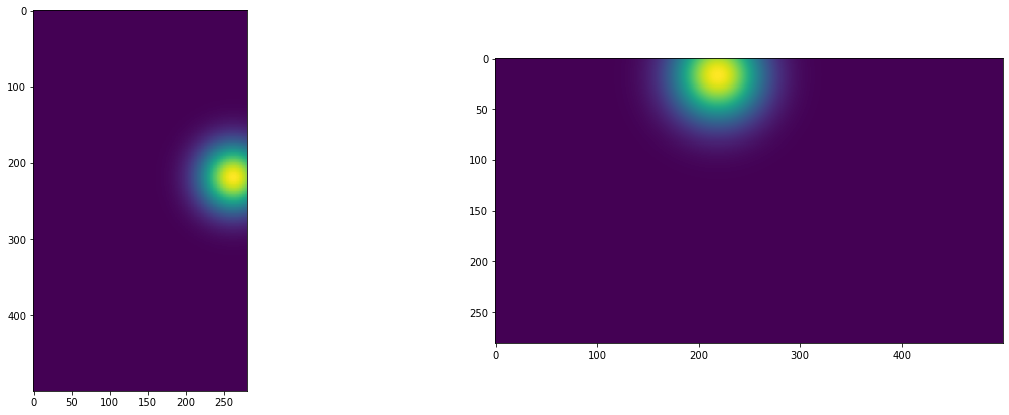

In [ ]:
f, ss = plt.subplots(1,2,figsize=(20,7))
ss[0].imshow(rf.reshape(stim.y.T.shape))
ss[1].imshow(np.rot90(rf.reshape(stim.y.T.shape)))